In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, pathlib

import numpy as np
import pandas as pd
import torch
import warp as wp
wp.config.quiet = True
wp.set_device('cpu')

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [3]:
config = project.core.fileio.load_json('2025-11-05_config.json')
config

Loading 2025-11-05_config.json


{'dataset': 'shapenet',
 'data_root': '/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem',
 'examples': {'unit_policy': 'prefer_metadata',
  'default_unit': 0.01,
  'volume_tag': 'volume_vr',
  'mat_fields_tag': 'mat_fields_vr',
  'sim_fields_tag': 'sim_fields_vr',
  'img_fields_tag': 'img_fields_vr',
  'material_tag': 'material_vr',
  'image_tag': 'solid_texture_vr'},
 'preprocess': {'preprocess_binary_mask': {'pad_factor': 0.37},
  'preprocess_surface_mesh': {},
  'create_mesh_region_mask': {},
  'create_volume_mesh_from_mask': {'use_affine_spacing': False,
   'pygalmesh_kws': {'max_facet_distance': 0.75,
    'max_cell_circumradius': 5.0,
    'lloyd': True,
    'odt': True}},
  'create_material_mask': {'sample_kws': {'vote_rate': 0.0001}},
  'create_mesh_fields': {},
  'simulate_displacement_field': {'nu_value': 0.4,
   'scalar_degree': 0,
   'vector_degree': 1,
   'solver_kws': {}},
  'generate_volumetric_image': {'annot_path': '/ocean/projects/asc170022p/mtragoza/lu

In [4]:
%autoreload
ds = project.datasets.shapenet.ShapeNetDataset(data_root='../../data/ShapeNetSem')
ds.load_metadata()

csv_path = '2025-11-05_optimized.csv'
selected = pd.read_csv(csv_path)
subjects = list(selected.subject)[:10]
examples = list(ds.examples(subjects, variant='2025-11-02', **config['examples']))

len(examples)

10

In [5]:
import project.training
train_ex, test_ex, val_ex = project.training.split_by_category(examples, 0.20, 0.10, seed=0)
len(train_ex), len(test_ex), len(val_ex)

0.2


(7, 2, 1)

In [6]:
import project.datasets.torch

loader_kws = dict(
    batch_size=1,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=project.datasets.torch.collate_fn
)

train_set = project.datasets.torch.TorchDataset(train_ex)
train_loader = torch.utils.data.DataLoader(train_set, **loader_kws)

if test_ex:
    test_set = project.datasets.torch.TorchDataset(test_ex)
    test_loader = torch.utils.data.DataLoader(test_set, **loader_kws)
else:
    test_set = test_loader = None

if val_ex:
    val_set = project.datasets.torch.TorchDataset(val_ex)
    val_loader = torch.utils.data.DataLoader(val_set, **loader_kws)
else:
    val_set = val_loader = None


In [7]:
%autoreload
import project.model

model = project.model.UNet3D(
    in_channels=1,
    out_channels=1,
    conv_channels=8,
    n_enc_blocks=3,
    n_init_units=1,
    n_conv_units=2,
    norm_type='group',
    output_func='pow10'
).cuda()

bias_init = 2.0
with torch.no_grad():
    model.output_conv.bias.fill_(bias_init)

n_params = project.model.count_params(model)
n_params

encoder.level0.conv_block.unit0.conv.weight        216	(8, 1, 3, 3, 3)
encoder.level0.conv_block.unit0.norm.weight        8	(8,)
encoder.level0.conv_block.unit0.norm.bias          8	(8,)
encoder.level1.conv_block.unit0.conv.weight        3456	(16, 8, 3, 3, 3)
encoder.level1.conv_block.unit0.norm.weight        16	(16,)
encoder.level1.conv_block.unit0.norm.bias          16	(16,)
encoder.level1.conv_block.unit1.conv.weight        6912	(16, 16, 3, 3, 3)
encoder.level1.conv_block.unit1.norm.weight        16	(16,)
encoder.level1.conv_block.unit1.norm.bias          16	(16,)
encoder.level2.conv_block.unit0.conv.weight        13824	(32, 16, 3, 3, 3)
encoder.level2.conv_block.unit0.norm.weight        32	(32,)
encoder.level2.conv_block.unit0.norm.bias          32	(32,)
encoder.level2.conv_block.unit1.conv.weight        27648	(32, 32, 3, 3, 3)
encoder.level2.conv_block.unit1.norm.weight        32	(32,)
encoder.level2.conv_block.unit1.norm.bias          32	(32,)
decoder.level1.conv_block.unit0.conv

86929

In [8]:
image = train_set[0]['image'].unsqueeze(0).cuda()
E_true = train_set[0]['elast'].unsqueeze(0).cuda()
n_activs, E_pred = project.model.count_activations(model, image, ret_output=True)

Loading ../../data/ShapeNetSem/2025-11-02/100f39dce7690f59efb94709f30ce0d2/images/solid_texture_vr.nii.gz
Loading ../../data/ShapeNetSem/2025-11-02/100f39dce7690f59efb94709f30ce0d2/masks/material_vr.nii.gz
Loading ../../data/ShapeNetSem/2025-11-02/100f39dce7690f59efb94709f30ce0d2/meshes/img_fields_vr.xdmf
Loading ../../data/ShapeNetSem/2025-11-02/100f39dce7690f59efb94709f30ce0d2/fields/elasticity.nii.gz
input                                    11239424	(1, 1, 224, 224, 224)	torch.float32	0.0345	0.1374
encoder.level0.conv_block.unit0.conv     89915392	(1, 8, 224, 224, 224)	torch.float32	-0.0187	0.1618
encoder.level0.conv_block.unit0.norm     89915392	(1, 8, 224, 224, 224)	torch.float32	-0.0000	0.9994
encoder.level1.conv_block.unit0.conv     22478848	(1, 16, 112, 112, 112)	torch.float32	0.1382	1.0677
encoder.level1.conv_block.unit0.norm     22478848	(1, 16, 112, 112, 112)	torch.float32	-0.0000	1.0000
encoder.level1.conv_block.unit1.conv     22478848	(1, 16, 112, 112, 112)	torch.float32	-

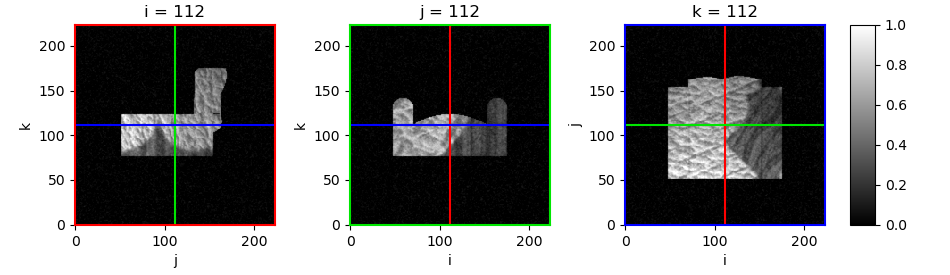

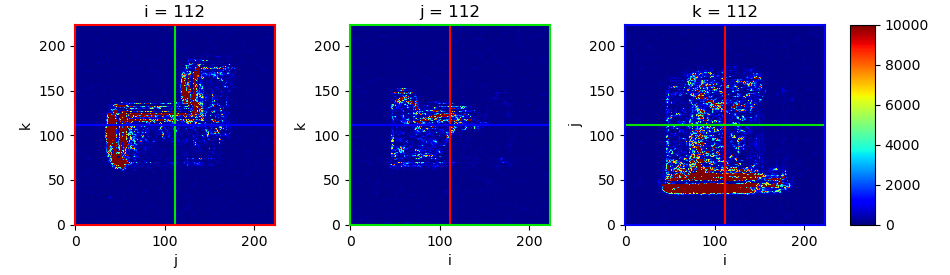

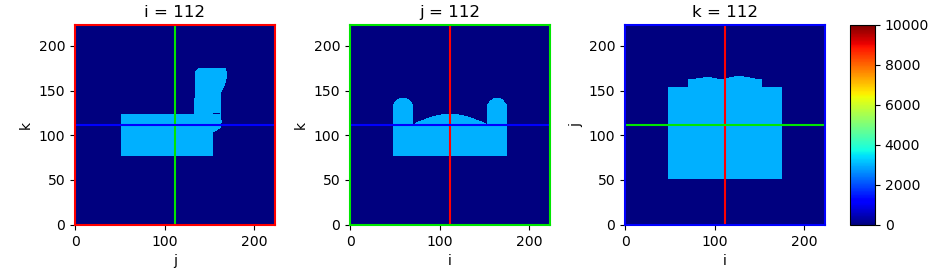

In [9]:
import project.visual.matplotlib
_ = project.visual.matplotlib.show_image_slices(image[0][0].detach().cpu().numpy(), cmap='gray', clim=(0,1))
_ = project.visual.matplotlib.show_image_slices(E_pred[0][0].detach().cpu().numpy(), cmap='jet', clim=(0,1e4))
_ = project.visual.matplotlib.show_image_slices(E_true[0][0].detach().cpu().numpy(), cmap='jet', clim=(0,1e4))

In [10]:
model_mib = (n_activs + n_params) * 2 * 4 / 2**20 # MiB
model_mib

2873.288215637207

In [11]:
import torch.optim
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0.01
)

In [12]:
%autoreload
import project.training
import project.evaluation
import warp as wp
wp.config.quiet = True

evaluator = project.evaluation.Evaluator()
trainer = project.training.Trainer(
    model,
    optimizer,
    train_loader,
    test_loader,
    val_loader,
    evaluator,
    solver_kws=dict(tv_reg_weight=1e-4),
    supervised=False
)

In [ ]:
trainer.train(num_epochs=100, save_path='test.checkpoint')

[Epoch 0 | Val batch 1/1]
Val metrics @ epoch 0: 
   epoch phase  batch      loss                               subject  \
0      0   val      0  0.720123  wss.111cb08c8121b8411749672386e0b711   

   num_voxels  E_voxel.norm   E_voxel.rms  E_voxel.rmse  E_voxel.nrmse  ...  \
0      212752  7.524599e+14  2.790213e+17  2.790213e+17   9.300709e+13  ...   

   E_cell.pcorr  E_cell.scorr  u_cell.norm  u_cell.rms  u_cell.rmse  \
0           NaN           NaN     0.000636    0.001114     0.004672   

   u_cell.nrmse  u_cell.pcorr  u_cell.scorr  res_cell.norm  res_cell.rms  
0      0.839956      0.813309      0.845975       0.215383      0.391778  

[1 rows x 26 columns]
Saving test.checkpoint
[Epoch 0 | Train batch 1/7] loss = 0.7613 | time = 71.8033
[Epoch 0 | Train batch 2/7] loss = 754.6589 | time = 0.5110
[Epoch 0 | Train batch 3/7] loss = 0.7562 | time = 0.6350
[Epoch 0 | Train batch 4/7] loss = 1.0479 | time = 0.4354
[Epoch 0 | Train batch 5/7] loss = 1.0225 | time = 0.3563
[Epoch 0 | T

In [14]:
pd.DataFrame(evaluator.example_rows['train'])

""
